In [18]:
import pandas as pd
import random
import os

from time import sleep

In [2]:
from dotenv import load_dotenv

In [3]:
load_dotenv(dotenv_path='/Users/daniel/OAN/SID/.env')

True

In [4]:
from imutils import paths

In [5]:
from googleapiclient.http import MediaFileUpload, MediaIoBaseDownload
from oauth2client import file,client, tools
from googleapiclient import discovery
from httplib2 import Http
## CONECTION TO DRIVE

SCOPES = ['https://www.googleapis.com/auth/drive'
        ]
store = file.Storage('/Users/daniel/OAN/credentials/storage.json')
creds = store.get()
if not creds or creds.invalid:
    flow = client.flow_from_clientsecrets('/Users/daniel/OAN/credentials/credentials.json', SCOPES)
    creds = tools.run_flow(flow, store)
drive_service = discovery.build('drive', 'v3', http=creds.authorize(Http()))

In [7]:
def upload_to_drive(file,filename,mimetype,folder_id):
    
    
    #metadatos del archivo
    file_metadata = {
        'name': filename,
        'parents': folder_id
    }
    media = MediaFileUpload(file,
                            mimetype=mimetype,
                            resumable=True)
    file = drive_service.files().create(body=file_metadata,
                                        media_body=media,
                                        supportsAllDrives=True,
                                        fields='id').execute()
    return file.get('id')

In [6]:
import numpy as np
from scipy.spatial import ConvexHull

def minimum_bounding_rectangle(points):
    """
    Find the smallest bounding rectangle for a set of points.
    Returns a set of points representing the corners of the bounding box.

    :param points: an nx2 matrix of coordinates
    :rval: an nx2 matrix of coordinates
    """
    from scipy.ndimage.interpolation import rotate
    pi2 = np.pi/2.

    # get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # calculate edge angles
    edges = np.zeros((len(hull_points)-1, 2))
    edges = hull_points[1:] - hull_points[:-1]

    angles = np.zeros((len(edges)))
    angles = np.arctan2(edges[:, 1], edges[:, 0])

    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # find rotation matrices
    # XXX both work
    rotations = np.vstack([
        np.cos(angles),
        np.cos(angles-pi2),
        np.cos(angles+pi2),
        np.cos(angles)]).T
#     rotations = np.vstack([
#         np.cos(angles),
#         -np.sin(angles),
#         np.sin(angles),
#         np.cos(angles)]).T
    rotations = rotations.reshape((-1, 2, 2))

    # apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    # find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # return the best box
    x1 = max_x[best_idx]
    x2 = min_x[best_idx]
    y1 = max_y[best_idx]
    y2 = min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2))
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)

    return rval

In [7]:
img_info = pd.read_gbq('SELECT * FROM sidhouses.water_zones.image_ds_info')

In [8]:
len(img_info)

102

In [9]:
img_info.head()

,drive_id,path,lat_0,lon_0,deg_per_px_lat,deg_per_px_lon,n_houses,layer
0,1NNYxYLGgtd0JgSX6_J9C6pnkNHFic0vL,/Users/daniel/OAN/SID/balsas/osm/balsa_3505568...,37.898052,-1.06580,0.000008,0.000011,1,pnoa
1,1VfMCT17FwTv5DdbNoODlnmmXsS2r6140,/Users/daniel/OAN/SID/balsas/osm/balsa_4890921...,37.902451,-1.03040,0.000008,0.000011,1,pnoa
2,1W7-WAL3ppcvwF3ohUalx8HMIumJXClJY,/Users/daniel/OAN/SID/balsas/osm/balsa_5278739...,37.885382,-1.24485,0.000008,0.000011,1,pnoa
3,1C3BAtJw1rMy-liKx63TNhphEy5PtRr9J,/Users/daniel/OAN/SID/balsas/osm/balsa_5304206...,38.107260,-1.13373,0.000008,0.000011,1,pnoa
4,1u0GO1QpG1Uqlg9pLYxus0lbkX-9tJynO,/Users/daniel/OAN/SID/balsas/osm/balsa_5425021...,37.996016,-1.08670,0.000008,0.000011,1,pnoa


In [13]:
images_path = 'image_ds'

In [15]:
for drive_id in img_info['drive_id'].to_list():
    file_data = drive_service.files().get_media(fileId=drive_id).execute()
    file = open(images_path+'/'+drive_id+'.png','wb')
    file.write(file_data)
    file.close()

In [16]:
imagePaths = list(paths.list_files(images_path))

In [22]:
e= pd.read_gbq('SELECT * FROM sidhouses.water_zones.image_ds')

In [23]:
e.head()

,drive_id,id,house,lat_px,lon_px
0,1p6-Lo12f5G32AABZNdC3dbWvsMPm2KK1,107695740,"[[1624.0483519147117, 479.69698697910553], [16...",417,1615
1,1p6-Lo12f5G32AABZNdC3dbWvsMPm2KK1,133329192,"[[1399.4863904762828, 52.35486996296234], [142...",59,1416
2,1p6-Lo12f5G32AABZNdC3dbWvsMPm2KK1,133329194,"[[577.3974202014608, 380.2393002541131], [532....",412,568
3,1p6-Lo12f5G32AABZNdC3dbWvsMPm2KK1,133329199,"[[272.5941469287401, 362.6316760664684], [343....",352,318
4,1p6-Lo12f5G32AABZNdC3dbWvsMPm2KK1,750255258,"[[155.7786792531531, 353.42044409777407], [71....",417,136


## CONVERT TO BOUNDING BOX

In [20]:
import cv2
import matplotlib.pyplot as plt

In [24]:
im = cv2.imread(images_path+'/'+'1p6-Lo12f5G32AABZNdC3dbWvsMPm2KK1.png')

In [25]:
e['len'] = e['house'].apply(lambda x: len(eval(x)))

In [30]:
im = cv2.imread(images_path+'/'+'1p6-Lo12f5G32AABZNdC3dbWvsMPm2KK1.png')
hous = e[e['len']==11]['house'].values[0]
house = [[int(h[0]),int(h[1])] for h in eval(hous)]
vertices = np.array(house,dtype=np.int32)
pts = vertices.reshape((-1,1,2))
cv2.polylines(im,[pts],isClosed=True,color=(0,0,255),thickness=3)
print(house)
mbr_0 = minimum_bounding_rectangle(np.array(house))
mbr = [[int(h[0]),int(h[1])] for h in mbr_0]
print(mbr)
vertices = np.array(mbr,dtype=np.int32)
pts = vertices.reshape((-1,1,2))
a=cv2.polylines(im,[pts],isClosed=True,color=(255,0,0),thickness=3)


[[1706, 431], [1674, 482], [1550, 432], [1536, 406], [1594, 378], [1606, 379], [1624, 388], [1635, 386], [1655, 379], [1665, 382], [1706, 431]]
[[1717, 403], [1562, 340], [1528, 423], [1683, 485]]


In [31]:
im.shape

(846, 1880, 3)

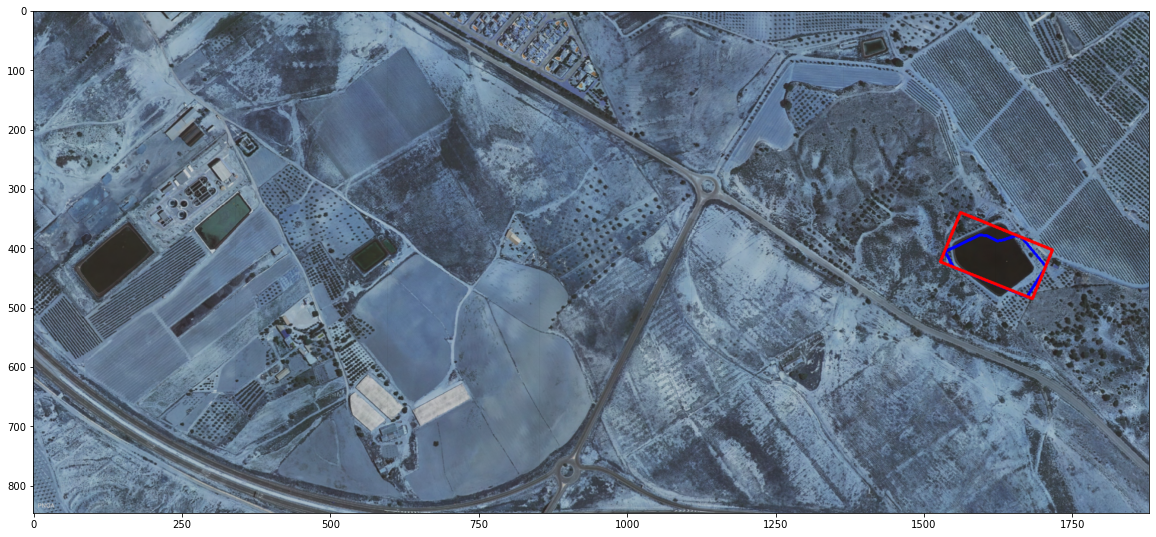

In [32]:
plt.figure(figsize=(20,10))
plt.imshow(im)

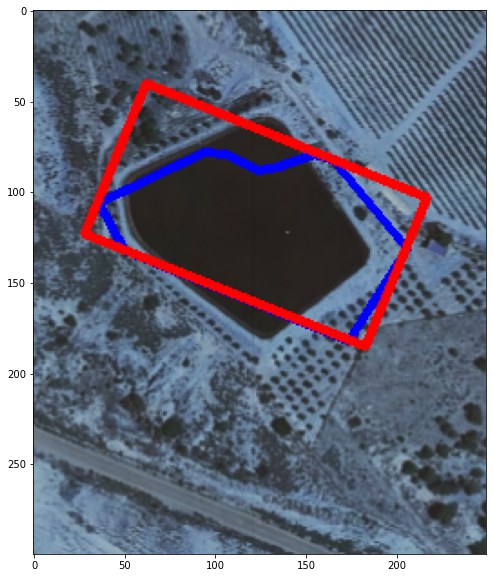

In [36]:
plt.figure(figsize=(20,10))
plt.imshow(im[300:600,1500:1750,:])

### GET MORE IMAGES OUT OF ONE

In [37]:
images_path = 'image_ds'

In [38]:
imagePaths = list(paths.list_files(images_path))

In [55]:
fname = '1p6-Lo12f5G32AABZNdC3dbWvsMPm2KK1'

reservoirs = pd.read_gbq('''SELECT * 
                                   FROM sidhouses.water_zones.image_ds 
                                   WHERE drive_id = '''+'"'+fname+'"')

In [56]:
len(reservoirs)

5

In [48]:
im.shape

(846, 1880, 3)

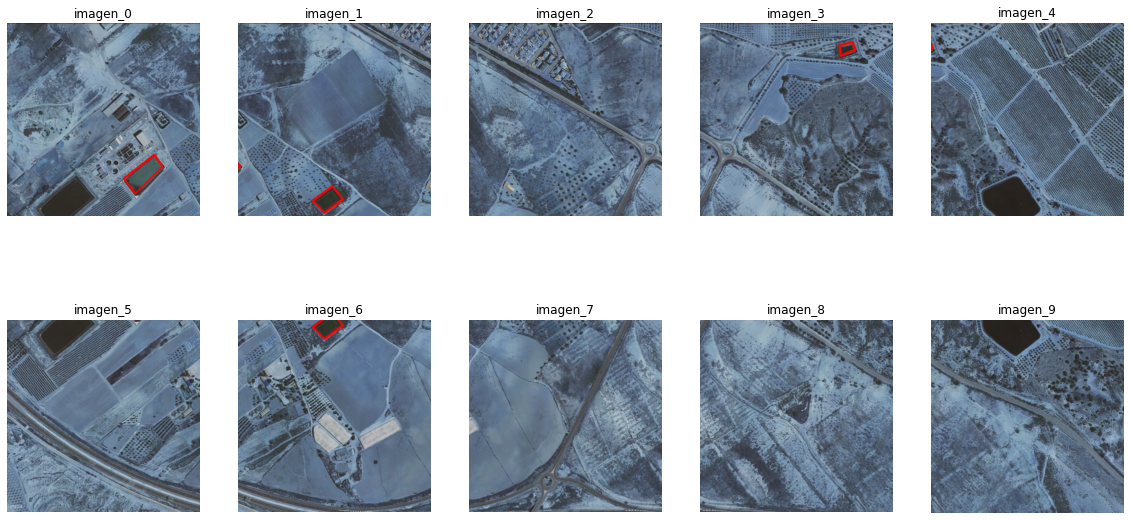

In [58]:
im = cv2.imread(images_path+'/'+'1p6-Lo12f5G32AABZNdC3dbWvsMPm2KK1.png')
n = 10
const = 450
delta_v = const - int((const*2-im.shape[0])/(2-1))
delta_h = const - int((const*(n/2)-im.shape[1])/((n/2)-1))
f, ax = plt.subplots(2,int(n/2),figsize=(20,10))
w = im.shape[1]
h = im.shape[0]

for a in range(int(n/2)):
    for b in range(2):
        y_0 = b * delta_v
        x_0 = a * delta_h
        new_im = im[y_0:(y_0+const),x_0:(x_0+const),:]
        for hous in reservoirs['house'].to_list():
            house = [[int(h[0]),int(h[1])] for h in eval(hous)]
            
            
            mbr_0 = minimum_bounding_rectangle(np.array(house))
            mbr = [[int(h[0]),int(h[1])] for h in mbr_0]
            
            #extract the label and bounding box coordinates
            label = 'house'
            xMin = min([h[0] for h in mbr])
            yMin = min([h[1] for h in mbr])
            xMax = max([h[0] for h in mbr])
            yMax = max([h[1] for h in mbr])

            # truncate any bounding box coordinates that fall outside
            # the boundaries of the image
            xMin = max(0, xMin)
            yMin = max(0, yMin)
            xMax = min(w, xMax)
            yMax = min(h, yMax)

            # ignore the bounding boxes where the minimum values are larger
            # than the maximum values and vice-versa due to annotation errors
            if xMin >= xMax or yMin >= yMax:
                continue
            elif xMax <= xMin or yMax <= yMin:
                continue
            min_ymax = yMax < (y_0+const)
            may_ymin = y_0 < yMin
            min_xmax = xMax < (x_0+const)
            may_xmin = x_0 < xMin
            
            if may_xmin and min_xmax and may_ymin and min_ymax:
                house_r = [[int(h[0]-x_0),+int(h[1]-y_0)] for h in house]
                vertices = np.array(house_r,dtype=np.int32)
                pts = vertices.reshape((-1,1,2))
                cv2.polylines(new_im,[pts],isClosed=True,color=(255,0,0),thickness=4)
            
        ax[b,a].imshow(new_im)
        ax[b,a].axis('off')
        ax[b,a].set_title('imagen_{}'.format(int(n/2*b+a)))
        cv2.imwrite('imagen_{}.jpg'.format(int(n/2*b+a)),new_im)

In [60]:
outputCSV = '_annotations.csv'

In [61]:
classes_csv = 'classes.csv'

In [62]:
len(imagePaths)

102

In [66]:
# open the output CSV file
csv = open(outputCSV, "w")
row = ['filename','width','height','class','xmin','ymin','xmax','ymax']
csv.write("{}\n".format(",".join(row)))

# loop over the image paths
for imagePath in imagePaths:
    # build the corresponding annotation path
    fname = imagePath.split('/')[-1].split('.')[0]
    reservoirs = pd.read_gbq('''SELECT * 
                                   FROM sidhouses.water_zones.image_ds 
                                   WHERE drive_id = '''+'"'+fname+'"')
    
    im = cv2.imread(imagePath)
    n = 10
    delta_v = 450 - int((450*2-im.shape[0])/(2-1))
    delta_h = 450 - int((450*(n/2)-im.shape[1])/((n/2)-1))
    w = im.shape[1]
    h = im.shape[0]

    for a in range(int(n/2)):
        for b in range(2):
            y_0 = b * delta_v
            x_0 = a * delta_h
            new_im = im[y_0:(y_0+450),x_0:(x_0+450),:]
            for hous in reservoirs['house'].to_list():
                house = [[int(h[0]),int(h[1])] for h in eval(hous)]


                mbr_0 = minimum_bounding_rectangle(np.array(house))
                mbr = [[int(h[0]),int(h[1])] for h in mbr_0]

                #extract the label and bounding box coordinates
                label = 'reservoirs'
                xMin = min([h[0] for h in mbr])
                yMin = min([h[1] for h in mbr])
                xMax = max([h[0] for h in mbr])
                yMax = max([h[1] for h in mbr])

                # truncate any bounding box coordinates that fall outside
                # the boundaries of the image
                xMin = max(0, xMin)
                yMin = max(0, yMin)
                xMax = min(w, xMax)
                yMax = min(h, yMax)

                # ignore the bounding boxes where the minimum values are larger
                # than the maximum values and vice-versa due to annotation errors
                if xMin >= xMax or yMin >= yMax:
                    continue
                elif xMax <= xMin or yMax <= yMin:
                    continue
                min_ymax = yMax < (y_0+450)
                may_ymin = y_0 < yMin
                min_xmax = xMax < (x_0+450)
                may_xmin = x_0 < xMin

                if may_xmin and min_xmax and may_ymin and min_ymax:
                    house_r = [[int(h[0]-x_0),+int(h[1]-y_0)] for h in house]
                    mbr_0 = minimum_bounding_rectangle(np.array(house_r))
                    mbr = [[int(h[0]),int(h[1])] for h in mbr_0]

                    #extract the label and bounding box coordinates
                    xMin = min([h[0] for h in mbr])
                    yMin = min([h[1] for h in mbr])
                    xMax = max([h[0] for h in mbr])
                    yMax = max([h[1] for h in mbr])

                    # truncate any bounding box coordinates that fall outside
                    # the boundaries of the image
                    xMin = max(0, xMin)
                    yMin = max(0, yMin)
                    xMax = min(w, xMax)
                    yMax = min(h, yMax)
                    ip = imagePath.split('.')
                    new_path = ip[0].replace('ds','ds10')+'_{}.'.format(int(n/2*b+a))+ip[1]
                                                                        
                    cv2.imwrite(new_path,new_im)
                    # write the image path, bb coordinates, label to the output CSV
                    row = [new_path.split('/')[-1],'450','450',label,str(xMin), str(yMin), str(xMax),
                            str(yMax)]
                    csv.write("{}\n".format(",".join(row)))


# close the CSV file
csv.close()


In [76]:
df = pd.read_csv('image_ds10/'+outputCSV)

In [77]:
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,1e-DeaN5rFXas2CQWS5YEv93vVPxaoeqn_0.png,450,450,reservoirs,359,350,423,405
1,1e-DeaN5rFXas2CQWS5YEv93vVPxaoeqn_0.png,450,450,reservoirs,302,287,344,328
2,1e-DeaN5rFXas2CQWS5YEv93vVPxaoeqn_0.png,450,450,reservoirs,186,105,212,131
3,1e-DeaN5rFXas2CQWS5YEv93vVPxaoeqn_0.png,450,450,reservoirs,139,357,160,378
4,1e-DeaN5rFXas2CQWS5YEv93vVPxaoeqn_0.png,450,450,reservoirs,100,294,114,307


In [82]:
df[['filename','xmin','ymin','xmax','ymax','class']].to_csv('image_ds10/'+outputCSV,header=False,index=False)

In [79]:
df.shape

(927, 8)

In [69]:
CLASSES = {'reservoirs'}

In [83]:
csv = open(classes_csv, "w")
rows = [",".join([ str(i),c]) for (i,c) in enumerate(CLASSES)]
csv.write("\n".join(rows))
csv.close()

In [84]:
CLASSES

{'reservoirs'}

In [72]:
images_path = 'image_ds10'

In [73]:
imagePaths10 = list(paths.list_files(images_path))

In [74]:
len(imagePaths10)

431


### UPLOAD to ROBOFLOW

In [16]:
path = 'reservior_sid.v2-rotated.retinanet/train'
l_files = os.listdir(path)
len(l_files)

917

In [15]:
l_files[0]

'1NZ60aDZXqwFVb3aKyZopkLmpLdJKhRWe_3_png.rf.fbd98ef9679e6cb71d109b564d758223.jpg'

In [21]:
for f in l_files:
    drive_id = upload_to_drive(path+'/'+f,
                               f,
                               'image/jpeg',
                               ['1NcFgaZF6eBo844CPo2EWlpAYcdhGWgDG'])
    sleep(0.5)